#  Problem Statement: Recommendation system for products on an e-commerce website like Amazon.com. 

# Dataset columns​ -
    **  first three columns are userId, productId, and ratings and the fourth column is timestamp. You can discard the timestamp column as in this case you may not need to use it. 

# Source​ - 
    ** Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/)  The repository has several datasets. For this case study, we are using the Electronics dataset. 

# Steps - 
**1. Read and explore the given dataset.  ( Rename column/add headers, plot histograms, find data characteristics)** 

**2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings )**

**3. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)**

**4. Build Popularity Recommender model.**

**5. Build Collaborative Filtering model.**

**6. Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (like RMSE) on predictions made on the test data.) You can also use a different method to evaluate the models.**

**7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.**

**8. Summarise your insights.** 
 

# Load necessary libraries

In [336]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [337]:
from surprise import KNNBasic, SVD, NormalPredictor, KNNBaseline,KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering, Reader, dataset, accuracy

# Read and explore the dataset  ( Rename column/add headers, plot histograms, find data characteristics) 

In [338]:
columns = ['userID', 'productID', 'ratings','timestamp']

recomm_df = pd.read_csv('ratings_Electronics.csv',names=columns)

In [339]:
recomm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
userID       object
productID    object
ratings      float64
timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [340]:
recomm_df.head()

,userID,productID,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [341]:
recomm_df.shape

(7824482, 4)

In [342]:
recomm_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ratings,7824482.0,4.012337e+00,1.380910e+00,1.0,3.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
timestamp,7824482.0,1.338178e+09,6.900426e+07,912729600.0,1.315354e+09,1.361059e+09,1.386115e+09,1.406074e+09


#  Dropping the "timestamp" as it is not a needed field

In [343]:
recomm_df = recomm_df.drop('timestamp', axis=1)

# Missing Value

In [344]:
recomm_df.isna().sum()

userID       0
productID    0
ratings      0
dtype: int64

In [345]:
recomm_df.shape

(7824482, 3)

# plot histograms

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CEC90CC2B0>]],
      dtype=object)

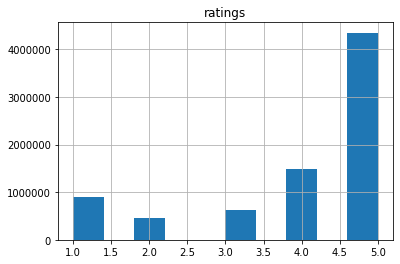

In [346]:
recomm_df.hist('ratings',bins = 10)

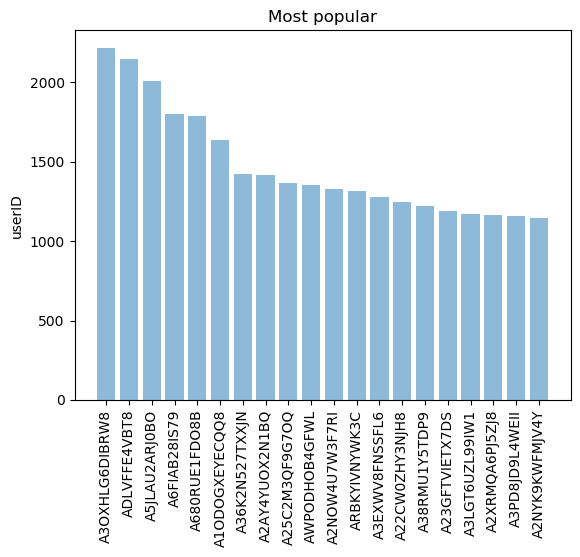

In [347]:
popular = recomm_df[['userID','ratings']].groupby('userID').sum().reset_index()
popular_20 = popular.sort_values('ratings', ascending=False).head(n=20)
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = (list(popular_20['userID']))
y_pos = np.arange(len(objects))
performance = list(popular_20['ratings'])
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('userID')
plt.title('Most popular')
 
plt.show()

In [348]:
# find unique users
recomm_df.userID.value_counts()

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
ARBKYIVNYWK3C     296
A22CW0ZHY3NJH8    292
A38RMU1Y5TDP9     282
A3EXWV8FNSSFL6    282
A3LGT6UZL99IW1    279
A2NOW4U7W3F7RI    277
A23GFTVIETX7DS    270
A3PD8JD9L4WEII    266
A17BUUBOU0598B    261
A3AYSYSLHU26U9    257
A2XRMQA6PJ5ZJ8    253
A231WM2Z2JL0U3    252
A12DQZKRKTNF5E    252
A1UQBFCERIP7VJ    247
AGVWTYW0ULXHT     244
A203OCQQ12MAVT    240
AEJAGHLC675A7     239
A2NYK9KWFMJV4Y    238
A3A4ZAIBQWKOZS    236
A2UOHALGF2X77Q    227
                 ... 
AZ4PSN6HV6UQN       1
A2GB9KOC5NBDVV      1
A3IXZBXE6WJGVX      1
A121SXNYJVLKCF      1
A3UBEXWAT1S934      1
A630GZRAAJET7       1
A13EWF11W06SXA      1
A2BOVYQ6C0CGJE      1
A2G1EVUPBWUXH2      1
A2J3YEKII1LM1O      1
A3PEZFQ6A5CWQF      1
A14Y04LQV1LGO4      1
A2USGKKRIT16AL      1
A8JFJ4J8GI1EI       1
AVR924H630

In [349]:
print('Number of unique users', len(recomm_df['userID'].unique()))

Number of unique users 4201696


In [350]:
print('Number of unique products', len(recomm_df['productID'].unique()))

Number of unique products 476002


In [351]:
print('Unique Ratings', recomm_df['ratings'].unique())

Unique Ratings [5. 1. 3. 2. 4.]


In [352]:
min_ratings1 = recomm_df[(recomm_df['ratings'] < 2.0)]

In [353]:
print('Number of unique products rated low',len(min_ratings1['productID'].unique()))

Number of unique products rated low 176283


In [354]:
med_ratings1 = recomm_df[(recomm_df['ratings'] > 2.0) & (recomm_df['ratings'] < 4.0)]

In [355]:
print('Number of unique products rated medium',len(med_ratings1['productID'].unique()))

Number of unique products rated medium 152827


In [356]:
max_ratings1 = recomm_df[recomm_df['ratings'] >= 4.0]

In [357]:
print('Number of unique products rated high',len(max_ratings1['productID'].unique()))

Number of unique products rated high 410110


In [358]:
avg_rating_prod = recomm_df.groupby('productID').sum() / recomm_df.groupby('productID').count()

In [359]:
avg_rating_prod.drop('userID', axis=1,inplace =True)

In [360]:
print ('Top 10 highly rated products \n',avg_rating_prod.nlargest(10,'ratings'))

Top 10 highly rated products 
             ratings
productID          
0132793040      5.0
0321732944      5.0
059400232X      5.0
0594033934      5.0
0594287995      5.0
0594450209      5.0
0594450705      5.0
0594511488      5.0
0594514789      5.0
0594549558      5.0


# Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings )

In [361]:
userID = recomm_df.groupby('userID').count()

In [362]:
top_user = userID[userID['ratings'] >= 50].index

In [363]:

topuser_ratings_df = recomm_df[recomm_df['userID'].isin(top_user)]

In [364]:
#topuser_ratings_df.drop('productID', axis=1, inplace = True)

In [365]:
topuser_ratings_df.shape

(125871, 3)

In [366]:
topuser_ratings_df.head()

,userID,productID,ratings
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


In [367]:
topuser_ratings_df.sort_values(by='ratings', ascending=False).head()

,userID,productID,ratings
94,A3BY5KCNQZXV5U,0594451647,5.0
4256669,A680RUE1FDO8B,B004M8RWDE,5.0
4258497,AOMEH9W6LHC4S,B004M8SBNE,5.0
4258199,A2GKMXRLI7KLFP,B004M8SBD4,5.0
4258099,A1UNJ46NSB352E,B004M8SBCK,5.0



# Keep data only for products that have 50 or more ratings

In [368]:
prodID = recomm_df.groupby('productID').count()

In [369]:
top_prod = prodID[prodID['ratings'] >= 50].index

In [370]:
top_ratings_df = topuser_ratings_df[topuser_ratings_df['productID'].isin(top_prod)]

In [371]:
top_ratings_df.sort_values(by='ratings', ascending=False).head()

,userID,productID,ratings
492,A3CLWR1UUZT6TG,0972683275,5.0
4220481,A2AY4YUOX2N1BQ,B004KJE8FU,5.0
4217715,A2Q204DY2L7YRP,B004K8WPUQ,5.0
4218748,A87CILADRIZW0,B004KA8Y4U,5.0
4219205,A11KZ906QD08C5,B004KCI80I,5.0


In [372]:
top_ratings_df.shape

(79182, 3)

# Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)

In [373]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(top_ratings_df, test_size = 0.30, random_state=0)

In [374]:
train_data.head()

,userID,productID,ratings
3679937,A2W0XCWOK3MW6F,B003Y74AXO,3.0
3603561,A2E1EFNIZL2FVA,B003VANO7C,5.0
6945634,AR3EVUQF0AC7R,B00ARB5FLQ,4.0
2732999,A38RMU1Y5TDP9,B002NGVY8G,1.0
7715921,A1JZFGZEZVWQPY,B00GRNUO2I,3.0


In [375]:
test_data.head()

,userID,productID,ratings
6562653,AWH2AY17ZU7W2,B009A6CZ30,5.0
1001830,A1SHHQSPOWR00F,B000HGIWN4,3.0
3904732,A1PVJICI412IN4,B00466X9SY,5.0
7600678,AGYH5U11ZKPFB,B00F3ZN0CC,4.0
2743475,AMKNPIDFLRFMP,B002O3W2OI,2.0


# Build Popularity Recommender model.

In [376]:
#Building the recommendations based on the average of all user ratings for each product.
train_data_grouped = train_data.groupby('productID').mean().reset_index()

In [377]:
train_data_grouped.head()

,productID,ratings
0,0972683275,4.5
1,1400501466,3.0
2,1400501520,5.0
3,1400501776,4.0
4,1400532620,1.0


In [378]:
train_data_sort = train_data_grouped.sort_values(['ratings', 'productID'], ascending=False)

In [379]:
train_data_sort.head()

,productID,ratings
14854,B00L3YHF6O,5.0
14851,B00K7O2DJU,5.0
14850,B00K4VQZCM,5.0
14849,B00K0OBEE2,5.0
14845,B00JLADOGW,5.0


In [380]:
train_data.groupby('productID')['ratings'].count().sort_values(ascending=False).head(10) 

productID
B0088CJT4U    135
B003ES5ZUU    128
B007WTAJTO    123
B000N99BBC    122
B008DWCRQW    102
B00829TIEK    102
B00829THK0     98
B002R5AM7C     94
B004CLYEDC     82
B004CLYEFK     76
Name: ratings, dtype: int64

In [410]:
ratings_mean_count = pd.DataFrame(train_data.groupby('productID')['ratings'].mean()) 

In [411]:
ratings_mean_count['rating_counts'] = pd.DataFrame(train_data.groupby('productID')['ratings'].count())  

In [412]:
ratings_mean_count.head()  

,ratings,rating_counts
productID,,
0972683275,4.5,2
1400501466,3.0,4
1400501520,5.0,1
1400501776,4.0,1
1400532620,1.0,1


In [413]:
pred_df = test_data[['userID', 'productID', 'ratings']]

In [414]:
pred_df.rename(columns = {'ratings' : 'true_ratings'}, inplace=True)

In [415]:
pred_df = pred_df.merge(train_data_sort, left_on='productID', right_on = 'productID')

In [417]:
pred_df.head(3)

,userID,productID,true_ratings,ratings
0,AWH2AY17ZU7W2,B009A6CZ30,5.0,4.5
1,A316XO4RWX21YN,B009A6CZ30,4.0,4.5
2,A1UNJ46NSB352E,B009A6CZ30,5.0,4.5


In [387]:
pred_df.rename(columns = {'ratings' : 'predicted_ratings'}, inplace = True)

In [388]:
pred_df.head()

,userID,productID,true_ratings,predicted_ratings
0,AWH2AY17ZU7W2,B009A6CZ30,5.0,4.5
1,A316XO4RWX21YN,B009A6CZ30,4.0,4.5
2,A1UNJ46NSB352E,B009A6CZ30,5.0,4.5
3,A1CMD08Z49PGKQ,B009A6CZ30,5.0,4.5
4,A1F9Z42CFF9IAY,B009A6CZ30,5.0,4.5


In [389]:
import sklearn.metrics as metric
from math import sqrt
MSE = metric.mean_squared_error(pred_df['true_ratings'], pred_df['predicted_ratings'])
print('The RMSE value for Popularity Recommender model is', sqrt(MSE))

The RMSE value for Popularity Recommender model is 1.0914119718039657


**The RMSE value for Popularity Recommender model is 1.091**

# Build Collaborative Filtering model

In [390]:
import surprise
from surprise import KNNWithMeans
from surprise.model_selection import GridSearchCV
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

In [391]:
reader = Reader(rating_scale=(0.5, 5.0))

# Converting Pandas Dataframe to Surpise format

In [392]:
data = Dataset.load_from_df(top_ratings_df[['userID', 'productID', 'ratings']],reader)

In [393]:
# Split data to train and test
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.3,random_state=0)

In [394]:
type(trainset)

surprise.trainset.Trainset

# Training the model

**KNNWithMeans**

In [395]:
algo_user = KNNWithMeans(k=10, min_k=6, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo_user.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


**SVD**

In [396]:
svd_model = SVD(n_factors=50,reg_all=0.02)
svd_model.fit(trainset)

#  Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (like RMSE) on predictions made on the test data.) You can also use a different method to evaluate the models.

 **Popularity Recommender Model (RMSE)**


In [397]:
MSE = metric.mean_squared_error(pred_df['true_ratings'], pred_df['predicted_ratings'])
print('The RMSE value for Popularity Recommender model is', sqrt(MSE))

The RMSE value for Popularity Recommender model is 1.0914119718039657


**Collaborative Filtering Recommender Model (RMSE)**

In [398]:
print(len(testset))
type(testset)

23755


list

**KNNWithMeans**

In [399]:
# Evalute on test set
test_pred = algo_user.test(testset)
test_pred[0]

Prediction(uid='A28UMA3GW9L124', iid='B001GX6MJ8', r_ui=3.0, est=3.3492063492063493, details={'actual_k': 2, 'was_impossible': False})

In [400]:
# compute RMSE
accuracy.rmse(test_pred) #range of value of error

RMSE: 0.9941


0.9940800621800723

**SVD**

In [401]:
test_pred = svd_model.test(testset)

In [402]:
# compute RMSE
accuracy.rmse(test_pred)

RMSE: 0.9606


0.9605860951788668

 **Parameter tuning of SVD Recommendation system**

In [403]:
from surprise.model_selection import GridSearchCV
param_grid = {'n_factors' : [5,10,15], "reg_all":[0.01,0.02]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3,refit = True)

In [404]:
gs.fit(data)

In [405]:
# get best parameters
gs.best_params

{'rmse': {'n_factors': 5, 'reg_all': 0.02}}

In [406]:
# Use the "best model" for prediction
gs.test(testset)
accuracy.rmse(gs.test(testset))

RMSE: 0.8582


0.8581532336596054

**The RMSE value for Collaborative Filtering model, byKNNWithMeans is 0.9941 and SVD is 0.9606. After parameter tuning of SVD it is 0.858**

# Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.

In [407]:
from collections import defaultdict
def get_top_n(predictions, n=5):
  
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [408]:
top_n = get_top_n(test_pred, n=5)

In [409]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A28UMA3GW9L124 ['B00HFRWWAM', 'B000M2GYF6', 'B008JJLW4M', 'B0002D6QJO', 'B000N99BBC']
A38NHXL5257E3B ['B00BOHNYU6', 'B00CB2F65O', 'B004Q3R9AQ', 'B003SGCO3E', 'B00829THK0']
A36IHC0K68NS2 ['B00HMREOLK', 'B004ING996', 'B00ATM1MGA', 'B009N8M2P6', 'B005DKZTNK']
A231WM2Z2JL0U3 ['B00005OQMO', 'B00008OE6I', 'B00004RC2D', 'B00004TDL2', 'B00008OE5G']
A2AC6GQ24S45GA ['B001TOD7ME', 'B009E6J1BU', 'B009VV56TY', 'B001S2RCWI', 'B008U3038I']
A3OXHLG6DIBRW8 ['B004CLYEFK', 'B001T9NUJE', 'B002VPE1X4', 'B001ID829O', 'B00461E7JE']
A2XA8CW5DF4MNZ ['B000TKHBDK', 'B00387EW1K', 'B001TOD7ME', 'B000MKKTJK', 'B000AP05BO']
AG35JCCQWDRCS ['B000068O16', 'B0036Q7MV0', 'B003ZSHNE0', 'B0045TYDNC', 'B001MSVPM6']
A2X3L31KCXBHCL ['B00829THEG', 'B0044DEDC0', 'B005EM6IAA', 'B000B63KSM', 'B002V1APJ2']
A33YZNZIRA3H97 ['B00BOHNYTW', 'B000O161X0', 'B00006I5J7', 'B004MT7GGG', 'B00BFO14W8']
AX05DBU8IRUWY ['B007WTAJTO', 'B006W8U2MU', 'B001L1H0SC', 'B00IKCQ0EK', 'B001FO4QHI']
A296QED1MV1V0J ['B0058G40O8', 'B00AXTQQDS', 'B008AST7R6',

A54S9CIUV5VNB ['B001TH7T2U', 'B00429N18S', 'B003XM1WE0', 'B00APCMMDG', 'B000RZQZM0']
A2BUQ240COLAOP ['B007SVHFXO', 'B0025PKFUI', 'B005CFLMNC', 'B0055CL5XE', 'B000MPDT06']
A100UD67AHFODS ['B005PQTYHE', 'B000Q8UAWY', 'B00108UNEY', 'B0071BTJPI', 'B002NU5S02']
A3FEGTOLCWXSV4 ['B008EQZ25K', 'B003ES5ZUU', 'B005J31BCO', 'B003ZSHNGS', 'B000AZ57M6']
A1RL1OTV8IJMVD ['B00D6XW62I', 'B005DQG5SC', 'B005KFONIU', 'B004CLYEFK', 'B0036RFGKS']
A3R1GJY2MY8041 ['B000QUUFRW', 'B000GHD73Y', 'B00BFDHV9E', 'B00006IW1X', 'B0056DV0L4']
A3QQCEQ33O0GJU ['B001CY0P7G', 'B000O8I474', 'B004Q81CKY', 'B004ALYGI2', 'B004SUO068']
A1C5TCCR2IGKBU ['B0019EHU8G', 'B001HSOFI2', 'B0002SAE56', 'B004TJ6JH6', 'B000FJEZ0C']
A2MSBIA18RXYQC ['B005GREK8K', 'B00719CH0O', 'B001EUG3II', 'B00JLADOGW', 'B003LT8OPU']
AZOK5STV85FBJ ['B000O5N5AI', 'B00068YUN4', 'B000GL3MOY', 'B00104XCVO', 'B000ERAOMS']
A38C12950IM24P ['B00G4UQ6U8', 'B00DTZYHX4', 'B0074BW614', 'B0071NWYP8', 'B005GI18EI']
A22MANL4US4RMY ['B0052SCU8U', 'B00FJRS5BA', 'B0036Q7MV0'

A18OTCHQ6MXD6X ['B002YTDE5I', 'B003NR57BY', 'B001CCAISE', 'B004RBX0GO', 'B0049XGNKK']
AXU8RH1DEV21H ['B00BQ4F9ZA', 'B000051299', 'B004OB0EBQ', 'B0009WU65I', 'B006B7R9PU']
A2ZDY0V4Q1SZD7 ['B003ES5ZUU', 'B001TH7GUU', 'B00483WRZ6', 'B008AST7R6', 'B004C9P9TM']
A10NMELR4KX0J6 ['B002VKVZ1A', 'B007SZ0EOW', 'B000YB862E', 'B003D0WIQS', 'B00466X9SY']
A2I18AO597DSDI ['B0032ANC5U', 'B006ZT4VA0', 'B004ROGUMC', 'B003B3P2BK', 'B004GAR91S']
A3HRDRQ5VAFPQS ['B006K551WQ', 'B000W09ZTK', 'B003LSTD38', 'B0092ML8QW', 'B00004ZC9V']
A11ULAZ4B5ZXC8 ['B0019EHU8G', 'B007YV0UQW', 'B0019SSSMY', 'B00698ZWOG', 'B0050NF926']
A132ETQPMHQ585 ['B000IJY8DS', 'B000LRMS66', 'B000BM8RFM', 'B007BYLO4E', 'B005TN0MMY']
A3S0DBBR693O06 ['B000ID7QNI', 'B0016LFN2C', 'B001MSU1HG', 'B0002JTD2K', 'B000067S60']
A3Q4TYJVAM4IRM ['B002BH3Z8E', 'B003UI62AG', 'B004CLYE8C', 'B000067RT6', 'B003I4FHNA']
A11EXFO14WEJM1 ['B001TH7T2U', 'B00E87E1OM', 'B0001G6U52', 'B003M0NURK', 'B000MANFIC']
AQ55H30MZSV0Q ['B0007LJHVA', 'B005S0XYKK', 'B007PJ4P4G'

# Summarise your insights

* We had read and explored the dataset. Considered only first three columns userId, productId, and ratings.

* Analysed the data and plotted the histogram based on ratings and usedID.

* We had Split the data randomly into train and test dataset.

**Build Popularity Recommender model and found the RMSE value for Popularity Recommender model as 1.091**

**Build Collaborative Filtering model.The RMSE value for Collaborative Filtering model, byKNNWithMeans is 0.9941 and SVD is 0.9606. After parameter tuning of SVD it is 0.858**

* We had recommended new products to each user based on his/her habits and have recommended 5 new products.

**Between RMSE of Popularity and Collaborative filtering , Collaborative fitering fares better with 0.86 scores.**

**Collaborative filtering uses user's behaviour (in this case explicit ratings to give) similar items / similar users and recomend products accordingly**

**Popularity based algorithm have their used cases when user would just like to browse most popular items**